In [1]:
from transformers import GPTNeoXForCausalLM, AutoTokenizer, AutoModel
from transformers.utils import WEIGHTS_NAME, CONFIG_NAME
from transformers.utils.hub import cached_file
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import json
import gzip
import json

/home/ec2-user/anaconda3/envs/mamba_out/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_json_gz(filename, num_inputs):
  with gzip.open(filename, 'r') as f:
      i = 0
      ret = []
      for json_line in f:
          if i == num_inputs:
              return ret
          data = json.loads(json_line)
          ret.append(data['text'])
          i += 1

def load_config_hf(model_name):
    resolved_archive_file = cached_file(model_name, CONFIG_NAME,
                                        _raise_exceptions_for_missing_entries=False)
    return json.load(open(resolved_archive_file))

In [3]:
num_inputs = 1024
strings = load_json_gz('c4-train.00000-of-01024.json.gz', num_inputs) # 356317 lines
max_seq_len = 1024
device = 'cuda'

In [4]:
# Angular distance from: https://arxiv.org/pdf/2403.17887.pdf

def batch_angular_distance(x, y):
    # x, y: (bs, seq_len, d_model)
    last_x = x[:, -1, :]  # Select the last tokens for each sequence in x, shape: (bs, d_model)
    last_y = y[:, -1, :]  # Select the last tokens for each sequence in y, shape: (bs, d_model)
    
    # Compute dot product for each pair in the batch
    dot_prod = (last_x * last_y).sum(dim=1)  # shape: (bs,)
    
    # Compute norms for each vector in the batch and then their product
    norm_x = torch.norm(last_x, dim=1)  # shape: (bs,)
    norm_y = torch.norm(last_y, dim=1)  # shape: (bs,)
    norm_prod = norm_x * norm_y  # shape: (bs,)
    
    # Compute angular distance
    cos_angle = dot_prod / norm_prod
    angle = torch.arccos(cos_angle) / torch.pi  # Ensure angle is in radians before dividing by pi
    
    return angle

def make_heatmap(tensor, block_size):
    ax = sns.heatmap(tensor, linewidth=0.5, cmap='viridis_r')
    ax.set_xlabel('Hidden Layer', fontsize=12)  # Set the x-axis label
    ax.set_ylabel('Block Size, n', fontsize=12)  # Set the y-axis label
    step = block_size // 4
    y_labels = range(block_size, 0, -step)
    ax.set_yticks(range(0, block_size, step))
    ax.set_yticklabels(y_labels)

def hidden_state_dist(model, tokenizer, block_size, batch_size, num_hidden_layers):
    sum = torch.zeros(block_size, num_hidden_layers)
    for bi in tqdm(range(0, num_inputs, batch_size)):
        cur_batch = []
        for count in range(batch_size):
            cur_batch.append(strings[count + bi])
        input_ids = tokenizer(cur_batch, return_tensors="pt", truncation=True, padding=True, max_length=max_seq_len).to(device)["input_ids"]
        with torch.no_grad():
            model_output = model(input_ids)
        for i in range(num_hidden_layers):
            i_hidden_state = model_output.hidden_states[i]
            for j in range(i+1, min(i+block_size+1, num_hidden_layers+1)):
                j_hidden_state = model_output.hidden_states[j]
                sum[block_size+i-j][i] += torch.sum(batch_angular_distance(i_hidden_state, j_hidden_state)).item()

    sum = torch.where(sum == 0, torch.tensor(float('nan')), sum)
    # Create a mask for non-nan values
    mask = ~torch.isnan(sum)
    # Use the mask to compute the min and max only on non-nan values
    min_val = torch.min(sum[mask])
    max_val = torch.max(sum[mask])
    # Normalize the tensor, ignoring nan values
    normalized_tensor = torch.where(mask, (sum - min_val) / (max_val - min_val), sum)
    make_heatmap(normalized_tensor, block_size)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 128/128 [01:04<00:00,  2.00it/s]


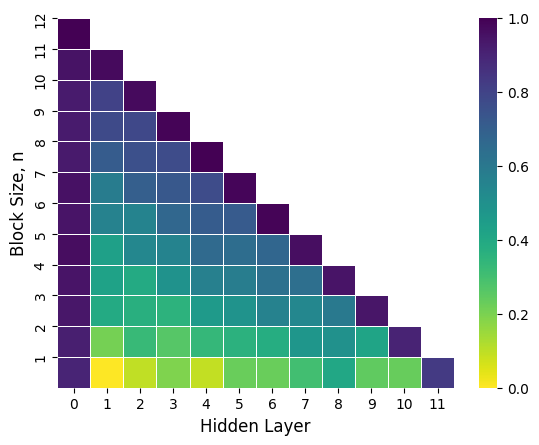

In [10]:
pretrained_model = "EleutherAI/pythia-160m"
config_data = load_config_hf(pretrained_model)
num_hidden_layers = config_data['num_hidden_layers']
d_model = config_data['hidden_size']
batch_size = 8
block_size = 12

model = AutoModel.from_pretrained(pretrained_model, output_hidden_states=True)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained(
  pretrained_model,
  padding_side="left",
  cache_dir=pretrained_model+'_tokenizer',
)
tokenizer.pad_token = tokenizer.eos_token
hidden_state_dist(model, tokenizer, block_size, batch_size, num_hidden_layers)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 128/128 [03:16<00:00,  1.53s/it]


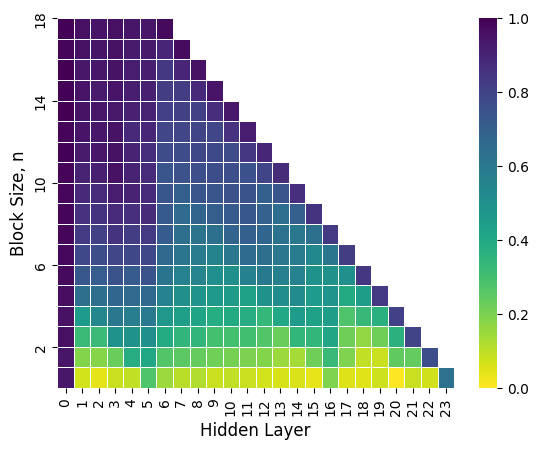

In [14]:
pretrained_model = "EleutherAI/pythia-410m"
config_data = load_config_hf(pretrained_model)
num_hidden_layers = config_data['num_hidden_layers']
d_model = config_data['hidden_size']
batch_size = 8
block_size = num_hidden_layers // 4 * 3

model = AutoModel.from_pretrained(pretrained_model, output_hidden_states=True)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained(
  pretrained_model,
  padding_side="left",
  cache_dir=pretrained_model+'_tokenizer',
)
tokenizer.pad_token = tokenizer.eos_token
hidden_state_dist(model, tokenizer, block_size, batch_size, num_hidden_layers)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 512/512 [06:32<00:00,  1.30it/s]


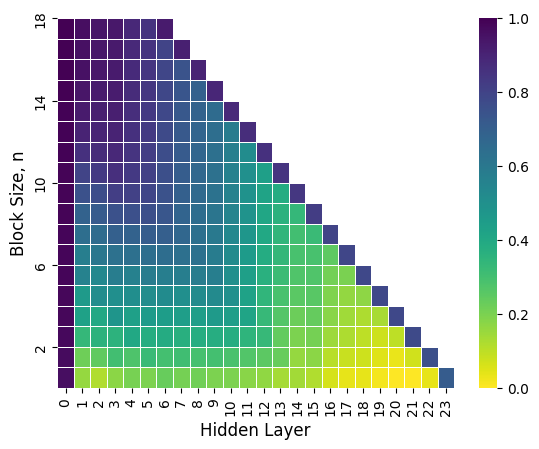

In [5]:
pretrained_model = "EleutherAI/pythia-1.4b"
config_data = load_config_hf(pretrained_model)
num_hidden_layers = config_data['num_hidden_layers']
d_model = config_data['hidden_size']
batch_size = 2
block_size = num_hidden_layers // 4 * 3

model = AutoModel.from_pretrained(pretrained_model, output_hidden_states=True)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained(
  pretrained_model,
  padding_side="left",
  cache_dir=pretrained_model+'_tokenizer',
)
tokenizer.pad_token = tokenizer.eos_token
hidden_state_dist(model, tokenizer, block_size, batch_size, num_hidden_layers)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 32/32 [01:12<00:00,  2.25s/it]


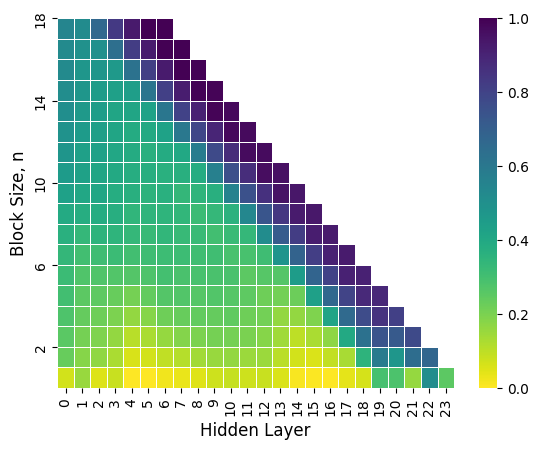

In [6]:
pretrained_model = "state-spaces/mamba-130m-hf"
config_data = load_config_hf(pretrained_model)
num_hidden_layers = config_data['num_hidden_layers']
d_model = config_data['hidden_size']
batch_size = 32
block_size = num_hidden_layers // 4 * 3

model = AutoModel.from_pretrained(pretrained_model, output_hidden_states=True)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained(
  pretrained_model,
  padding_side="left",
  cache_dir=pretrained_model+'_tokenizer',
)
tokenizer.pad_token = tokenizer.eos_token
hidden_state_dist(model, tokenizer, block_size, batch_size, num_hidden_layers)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 64/64 [03:37<00:00,  3.40s/it]


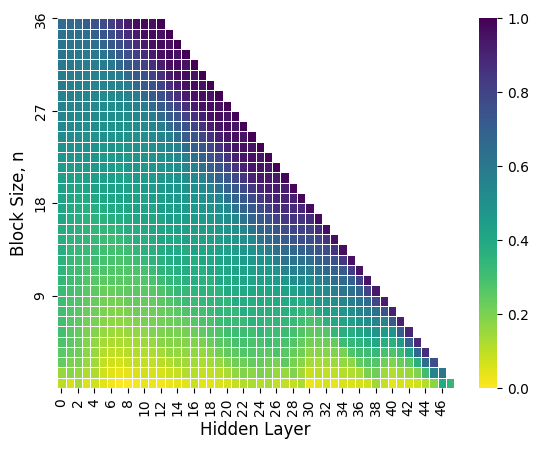

In [7]:
pretrained_model = "state-spaces/mamba-370m-hf"
config_data = load_config_hf(pretrained_model)
num_hidden_layers = config_data['num_hidden_layers']
d_model = config_data['hidden_size']
batch_size = 16
block_size = num_hidden_layers // 4 * 3

model = AutoModel.from_pretrained(pretrained_model, output_hidden_states=True)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained(
  pretrained_model,
  padding_side="left",
  cache_dir=pretrained_model+'_tokenizer',
)
tokenizer.pad_token = tokenizer.eos_token
hidden_state_dist(model, tokenizer, block_size, batch_size, num_hidden_layers)

Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.54s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 256/256 [09:33<00:00,  2.24s/it]


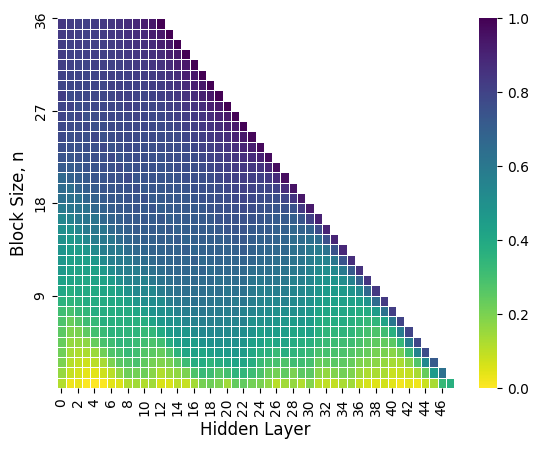

In [5]:
pretrained_model = "state-spaces/mamba-1.4b-hf"
config_data = load_config_hf(pretrained_model)
num_hidden_layers = config_data['num_hidden_layers']
d_model = config_data['hidden_size']
batch_size = 4
block_size = num_hidden_layers // 4 * 3

model = AutoModel.from_pretrained(pretrained_model, output_hidden_states=True)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained(
  pretrained_model,
  padding_side="left",
  cache_dir=pretrained_model+'_tokenizer',
)
tokenizer.pad_token = tokenizer.eos_token
hidden_state_dist(model, tokenizer, block_size, batch_size, num_hidden_layers)